# Maximum a Posteriori (MAP) estimate

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import jax
import jax.numpy as jnp
from jax import vmap, grad, jit
from jax import random

from gpx.models import GPR
from gpx.kernels import SquaredExponential
from gpx.parameters import Parameter
from gpx.priors import NormalPrior
from gpx.bijectors import Softplus
from gpx.mean_functions import zero_mean

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("dark_background")

%load_ext autoreload
%autoreload 2

We generate the same data as in the GPR example notebook

In [2]:
train_x = jnp.linspace(0, 1, 100)
key = random.PRNGKey(0)
train_y = jnp.sin(train_x * (2 * jnp.pi)) + random.normal(
    key, shape=train_x.shape
) * jnp.sqrt(0.04)
test_x = jnp.linspace(-0.5, 1.5, 51)
test_f = jnp.sin(test_x * (2 * jnp.pi))

train_x = train_x.reshape(-1, 1)
train_y = train_y.reshape(-1, 1)
test_x = test_x.reshape(-1, 1)
test_f = test_f.reshape(-1, 1)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


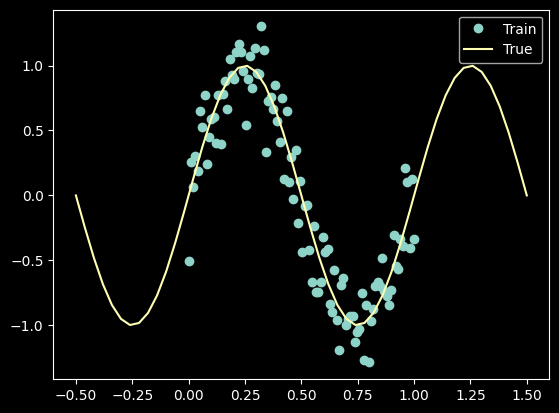

In [3]:
plt.plot(train_x, train_y, "o", label="Train")
plt.plot(test_x, test_f, label="True")
plt.legend()

When training the model, the default is to maximize the log marginal likelihood (LML)

In [4]:
# create a model with default parameters
model = GPR(
    kernel=SquaredExponential(),
)

model.print()

model.fit(train_x, train_y)

model.print()

┌────────────────────┬─────────────┬────────────┬──────────────────┬─────────┬─────────┬─────────┐
│ name               │ trainable   │ bijector   │ prior            │ dtype   │ shape   │   value │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼─────────┤
│ kernel lengthscale │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │       1 │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼─────────┤
│ sigma              │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │       1 │
└────────────────────┴─────────────┴────────────┴──────────────────┴─────────┴─────────┴─────────┘
┌────────────────────┬─────────────┬────────────┬──────────────────┬─────────┬─────────┬──────────┐
│ name               │ trainable   │ bijector   │ prior            │ dtype   │ shape   │    value │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼──────────┤
│ kerne

As you can see, the model parameters have a prior distribution associated with them.
In the LML, the prior information is not used.
If you train with multiple restarts, the prior is used just to sample new parameter values for a new optimization run.

If you want to incorporate prior information in the training objective, you can use a maximum a posteriori (MAP) estimation.
The MAP estimate maximizes the log posterior:

$$log p(\theta | y) = \log p(y | \theta) + log p(\theta)$$

where $\log p(y|\theta)$ is the LML.

In practice, you can specify the map loss as follows:

In [5]:
from gpx.models.gpr import neg_log_posterior # we minimize the negative log posterior (a loss)

# let's say we strongly believe that the lengthscale should have a value around 2
l = Parameter(value=2.0, trainable=True, bijector=Softplus(), prior=NormalPrior(2, 0.15))

model_map = GPR(
    kernel=SquaredExponential(),
    kernel_params=dict(lengthscale=l),
    loss_fn=neg_log_posterior, # MAP estimate
)

The prior on the lengthscale gives an almost-zero probability for the lengthscale's value obtained by maximizing the LML

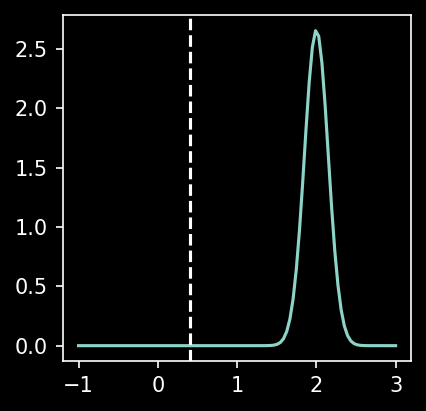

In [6]:
lml_val = model.state.params['kernel_params']['lengthscale'].value

prior = model_map.state.params['kernel_params']['lengthscale'].prior

fig, ax = plt.subplots(1,1, figsize=(3, 3), dpi=150)
xx = jnp.linspace(-1, 3, 100)
ax.plot(xx, jnp.exp(prior.logpdf(xx)))
ax.axvline(lml_val, ls='dashed')

As a consequence, the MAP estimate will be shifted towards the lengthscale prior

In [7]:
model_map.fit(train_x, train_y)

In [8]:
model_map.print()

┌────────────────────┬─────────────┬────────────┬───────────────────┬─────────┬─────────┬─────────┐
│ name               │ trainable   │ bijector   │ prior             │ dtype   │ shape   │   value │
├────────────────────┼─────────────┼────────────┼───────────────────┼─────────┼─────────┼─────────┤
│ kernel lengthscale │ True        │ Softplus   │ Normal(2.0, 0.15) │ float64 │ ()      │ 1.99896 │
├────────────────────┼─────────────┼────────────┼───────────────────┼─────────┼─────────┼─────────┤
│ sigma              │ True        │ Softplus   │ Normal(0.0, 1.0)  │ float64 │ ()      │ 0.4502  │
└────────────────────┴─────────────┴────────────┴───────────────────┴─────────┴─────────┴─────────┘


We can look at the LML and MAP shapes:

In [9]:
from gpx.models.gpr import neg_log_marginal_likelihood

ll = jnp.arange(0.01, 3.0, 0.1) # lengthscales

# copy a state that will be modified
state = model_map.state.copy()

lmls = []
lps = []
for l in ll:
    state.params['kernel_params']['lengthscale'] = state.params['kernel_params']['lengthscale'].update(dict(value=l))
    lmls.append(neg_log_marginal_likelihood(state, train_x, train_y))
    lps.append(neg_log_posterior(state, train_x, train_y))

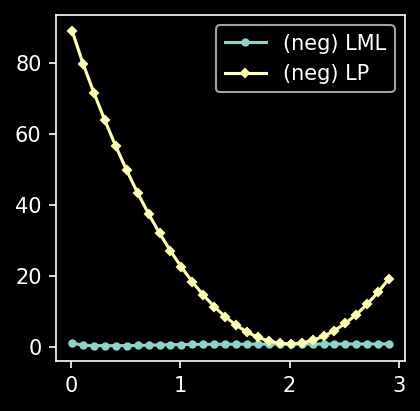

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)
ax.plot(ll, lmls, '-o', ms=3, label='(neg) LML')
ax.plot(ll, lps, '-D', ms=3, label='(neg) LP')
ax.legend()